# The Agent Loop: Building Production Agents with LangChain 1.0

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant

## Table of Contents:

- **Breakout Room #1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Breakout Room #2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# 🤝 Breakout Room #1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-OpenAI**: OpenAI model integrations
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **tiktoken**: Token counting for text splitting

In [ ]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-openai langsmith langgraph qdrant-client langchain-qdrant tiktoken nest-asyncio

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **OpenAI** - For the GPT-5 model
2. **LangSmith** - For tracing and observability (optional but recommended)

In [2]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - e3f463b8


## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [4]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatOpenAI(model="gpt-5", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

In [5]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Arrr, the capital o’ France be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [6]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [7]:
from langchain.agents import create_agent

# Create our first agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>


### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [8]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
To find 25 × 48, note that 25 × 4 = 100, so 25 × 48 = 25 × (4 × 12) = (25 × 4) × 12 = 100 × 12 = 1200.

Answer: 1200


In [9]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- Current time: 2026-01-23 17:06:56 (based on system time).
- Calculation: The current hour is 17, so 100 ÷ 17 ≈ 5.8823529412.

Reasoning: I checked the current time to get the hour (17) and then divided 100 by 17.


In [10]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]


[TOOL]
The current date and time is: 2026-01-23 17:06:56

[AI]


[TOOL]
The result of 100 / 17 is 5.882352941176471

[AI]
- Current time: 2026-01-23 17:06:56 (based on system time).
- Calculation: The current hour is 17, so 100 ÷ 17 ≈ 5.8823529412.

Reasoning: I checked the current time to get the hour (17) and then divided 100 by 17.


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [11]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]

[Node: tools]
The result of 0.15 * 250 is 37.5

[Node: model]
To find 15% of 250, multiply 250 by 0.15.

250 × 0.15 = 37.5

Answer: 37.5


---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:
There are two mechanisms:
1) The LLM that the agent is configured with has been trained to understand if the context requires a tool call or not. There is no hard and fast rule for this, it's just a matching process based on the docstrings we supply for when a tool should be used. The response of the model contains a list under `tool_calls`. If that list is empty it means that the model has decided it doesn't need to call any more tools and it has all the info it needs to generate the answer. That's when the agent responds.
2) The langchain framework allows for middleware hooks that can be inserted in different transition states of the agent ReAct loop and we can use those to limit how many iterations the model is called, or use timeouts, or other options to force the response even if the agent is "still" thinking.

## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:
The docstrings are parsed given the `@tool` annotation and they are inserted as the `description` parameter of a `Tool` object. The call to the LLM is a structured input (json) that not only includes the messages but also a section of `tools` with `name`, `description`, `parameters`, etc. for each tool. The LLM is trained to treat this part of the LLM request as special (and it's probably trained to handle tool definitions) when it reasons. The `description` is important because that's how we explain to the LLM when and how the tool can be used so we can help it decide when to match the need for the tool to be called. 

---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [20]:
### YOUR CODE HERE ###
import random
# Create your custom tool
@tool
def get_random_number(min: int, max: int) -> int:
    """Get a random integer number between a minimum and maximum value."""
    return random.randint(min, max)

# Add your tool to the tools list and create a new agent
tools.append(get_random_number)

new_agent = create_agent(
    model="gpt-4",
    tools=tools,
    system_prompt="""
    You are a game simulator that can play a game with the user. The user guesses the current time. 
    Then you roll a regular 6-sided die to get a margin of error in seconds. They win if their guess is within the margin of error.
    Explain your reasoning when you answer the user.
    """
    )

In [22]:
# Test your custom tool with the agent
response = new_agent.invoke(
    {"messages": [{"role": "user", "content": "The time is 5:31:30"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Agent Response:
You guessed the time to be 5:31:30. The actual time when you made the guess was 5:30:58. Therefore, you were off by 32 seconds. 

I rolled a 2 on the die, which means your guess needed to be within a 2-second margin of error to win. 

Since your error of 32 seconds is greater than this margin of error, you did not win this time. Please try again!
Full Agent Conversation:

[HUMAN]
The time is 5:31:30

[AI]


[TOOL]
The current date and time is: 2026-01-23 17:30:58

[AI]


[TOOL]
2

[AI]
You guessed the time to be 5:31:30. The actual time when you made the guess was 5:30:58. Therefore, you were off by 32 seconds. 

I rolled a 2 on the die, which means your guess needed to be within a 2-second margin of error to win. 

Since your error of 32 seconds is greater than this margin of error, you did not win this time. Please try again!


---
# 🤝 Breakout Room #2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the same Health & Wellness Guide from Session 2 to maintain continuity.

In [23]:
# Load the document using our aimakerspace utilities
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter

# Load the document
text_loader = TextFileLoader("data/HealthWellnessGuide.txt")
documents = text_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

Loaded 1 document(s)
Total characters: 16,206


In [24]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

Split into 41 chunks

Sample chunk:
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

In [25]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [26]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base


In [27]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [28]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
 memory and learning

Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consiste...

--- Document 2 ---
 Avoid caffeine after 2 PM
- Exercise regularly, but not too close to bedtime
- Limit alcohol and heavy meals before bed

Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit...

--- Document 3 ---
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the block
7. Upbeat music
8. Splash cold water on face

Sleep Checklist:
- Room temperature 65-68F
- Bla...


## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information.

In [29]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [30]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [31]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [44]:
from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time
]

wellness_middleware = [
    log_before_model,
    log_after_model,
    call_limiter
]

wellness_system_prompt = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-4",
    tools=rag_tools,
    system_prompt=wellness_system_prompt,
    middleware=wellness_middleware
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [45]:
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'tips for better sleep'}, 'id': 'call_pKfxTJmchrmi5ujW1mYhlH1z', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Sure, here are some tips for better sleep according to the wellness knowledge base:

1. Maintain a consistent sleep schedule, even during weekends
2. Establish a peaceful bedtime routine that could involve reading, gentle stretching, or taking a warm bath
3. Ensure that your bedroom is cool (within 65-68 degrees Fahrenheit), dark, and quiet. You could use blackout curtains or a sleep mask for darkness and consider white noise machines or earplugs for silence
4. Minimize exposure to screens 1-2 hours before bed
5. Avoid consuming caffeine after 2 PM
6. Exercise regularly, but refrain from doing so too close to bedtime
7. Limit alcohol a

In [46]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query
[LOG] Model call #3 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'stress and sleep management tips'}, 'id': 'call_3zUaDmTgxFwhjXTstxzLgsgs', 'type': 'tool_call'}]
[LOG] Model call #4 - Messages in state: 3
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '6 * 7'}, 'id': 'call_edeTNgvG4r4kWsZJWYxVLsOE', 'type': 'tool_call'}]
[LOG] Model call #5 - Messages in state: 5
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
I'm sorry you're dealing with stress and having troubles with sleep. Here are some strategies to help manage these issues:

**Immediate stress relief:**
1. Deep breathing: Inhale for 4 counts, hold for 4, exhale for 4
2. Progressive muscle relaxation: Tense and release muscle groups from toes to head
3. Grounding technique: Name 5 things you see, 4 you hear, 3 you feel, 2 you smell, 1 you taste
4. Take a short walk, prefer

In [47]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #6 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_GCXArS57wfbxcd7MIcPTZy3r', 'type': 'tool_call'}]
[LOG] Model call #7 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
The result of 125 multiplied by 8 is 1000.


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

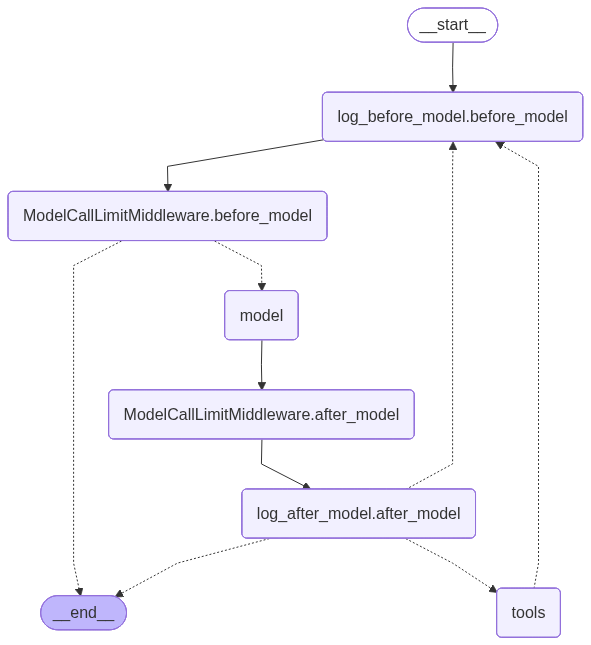

In [48]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information?

##### ✅ Answer:
##### Advantages:
- Wider variety of use cases it can support given that on top of simple retrieval-generation (which is limited by the data in your knowledge base) the agentic RAG can also leverage tools and also reasoning. Tools provide extensible capabilities and reasoning provides potentially better understanding of the query. Plain RAG is only good for search-like use cases or content-matching.
- Reasoning is a very powerful model for getting better answers and accurate results. It can solve more complex problems because the agent chooses when and how to retrieve information.
##### Disadvantages:
- Not as fine-grained control on the flow. It's non-deterministic when it decides to respond or how it will formulate the prompt it will send to the LLM. Then the LLM will non-deterministically choose the sequence of tools used. Plain RAG is consistent because the similarity metrics are deterministic for the same query. The only non-deterministic part is the reranking and how the LLM will package the information.
- More complex to debug and stabilize. There are more failure modes to consider given the non-determinism and the "connections" it makes. The more tools, or models, the more complex etc.
- Potentially slower to respond (multiple LLM calls involved) and less predictable execution time.


## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:
For production there are a few things that we would need to address:
1) **Traceability/Debugging/Reproducibility**: we need to be able to deal with production issues by collecting evidence related to the issue. I'd use hooks to log the state before and after the model call (since that's the least deterministic part of my loop). I'd use a hook to log the request and response of tools, especially the RAG and metadata of the response such as similarity metrics.
2) **Cost**: we need to understand our spending for these provider LLMs and since they charge by tokens, I'd put a hook before and after the LLM call that computes the number of tokens in and out. A second hook pre-LLM call that checks if we hit a developer-defined limit to exit.
3) **Latency**: our user experience could hurt if the agent takes long to respond. I'd put a hook before the request and after the response of the agent to capture the total time taken, as well as hook before and after the LLM call, and tool calls. Since LangChain v1.0 defines tools as a composition of both deterministic code and non-deterministic code (could be another agent under the hood) I'd also add pre and post hooks to capture tool response latency. To capture latency we'd need to store the before and after time in a store so the post-hook can calculate the difference in milliseconds.
4) **Context-Engineering**: the more messages we have in our list the more likely an LLM will "lose focus" and drop the quality of its responses. It is advised to compress the old context and a good way to do that is to use an LLM to summarize all the old messages. This could be done via a hook when the agent first kicks off (no need to do that all the time before we call an LLM) that checks the length of our message list and does the compression when we hit a threshold. This is one use case. We can imagine others where we might need to clean up the context in some way or rewrite things etc.
5) **Monitoring**: it's always useful to have some live stats from our agent that we can push to a DevOps monitoring system where we set up alerts if we hit certain metrics values or just to set up business dashboards. All the above hooks can be augmented send pings to our monitoring system (Grafana, Datadog, etc.) so we can keep track of how many requests per minute we receive or LLM usage, errors etc.

---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the wellness agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates BMI given height and weight
- A tool that estimates daily calorie needs
- A tool that creates a simple workout plan

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a friendly greeting to responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering
- Implement reranking of results
- Add source citations with relevance scores

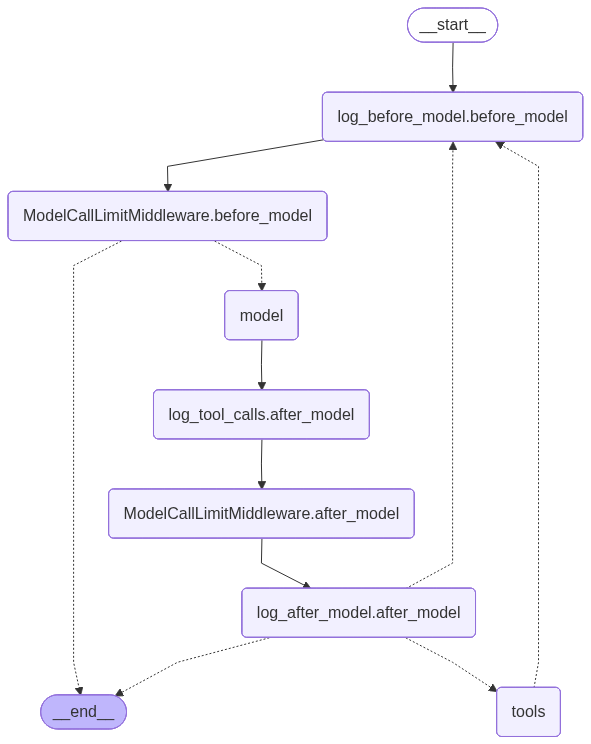

Created new wellness agent with tool calling stats


In [52]:
### YOUR CODE HERE ###

# Implement your enhancement below
db_tool_calls = {}
@after_model
def log_tool_calls(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls')
        if has_tool_calls:
            for tool_call in last_message.tool_calls:
                db_tool_calls[tool_call['name']] = db_tool_calls.get(tool_call['name'], 0) + 1
        most_used_tool = max(db_tool_calls, key=db_tool_calls.get)
        print(f"[LOG] After model - Most used tool: {most_used_tool} with {db_tool_calls[most_used_tool]} calls")
    return None

new_wellness_middleware = wellness_middleware + [log_tool_calls]
new_wellness_agent = create_agent(
    model="gpt-4",
    tools=rag_tools,
    system_prompt=wellness_system_prompt,
    middleware=new_wellness_middleware
)
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(new_wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(new_wellness_agent.get_graph().draw_ascii())

print("Created new wellness agent with tool calling stats")

In [53]:
# Test your enhanced agent here
# We send a couple of queries to collect some tool calling stats.

new_wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)
new_wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)
new_wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'd like to go to the gym, but every time I think about it I get lazy. What should I do?"}]}
)


[LOG] Model call #14 - Messages in state: 1
[LOG] After model - Most used tool: search_wellness_knowledge with 1 calls
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'tips for better sleep'}, 'id': 'call_g1RZ0AENaKNvSFEkUwNkXZgJ', 'type': 'tool_call'}]
[LOG] Model call #15 - Messages in state: 3
[LOG] After model - Most used tool: search_wellness_knowledge with 1 calls
[LOG] After model - Tool calls requested: []
[LOG] Model call #16 - Messages in state: 1
[LOG] After model - Most used tool: search_wellness_knowledge with 2 calls
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'stress management and sleep tips'}, 'id': 'call_rwPBqZiZfwe5dXUaqiia2FZW', 'type': 'tool_call'}]
[LOG] Model call #17 - Messages in state: 3
[LOG] After model - Most used tool: search_wellness_knowledge with 2 calls
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '6 * 7'}

{'messages': [HumanMessage(content="I'd like to go to the gym, but every time I think about it I get lazy. What should I do?", additional_kwargs={}, response_metadata={}, id='d72188ff-cf85-437e-908f-08c949c13dfe'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 333, 'total_tokens': 356, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-D1F63eD12o1D3DhtzgRhxfyxEGIWA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bebdd-ab24-76a1-9cca-87e733c159eb-0', tool_calls=[{'name': 'search_wellness_knowledge', 'args': {'query': 'overcoming gym laziness'}, 'id': 'call_iBMEhJ9QnV96QvRpBDg4u6es', 'type': 'tool_call